In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, fixed, ToggleButtons, IntSlider, FloatSlider
%matplotlib inline

# Define model (adjusted from IN's)

In [2]:
def model_afgeleiden(variables, t, beta, gamma):

    S = variables[0]
    I = variables[1]
    R = variables[2]
    
    S_new = -beta*I*S 
    I_new = beta*I*S - gamma*I
    R_new = gamma*I
    return [S_new, I_new, R_new]

def SIRmodel(tijdstappen, S_0, I_0, R_0, beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(beta, gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        modeloutput.plot()
    if returnDataFrame:
        return modeloutput 

# Load total infected from JHU

In [192]:
df_confd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [4]:
COVID19_totalConf = pd.DataFrame(df_confd.T[4:].sum(axis=1), columns=['TotalConfirmed'])

In [5]:
COVID19_totalConf.index = pd.to_datetime(COVID19_totalConf.index)

## Rework JHU data

In [199]:
df_world = df_confd.drop(df_confd[df_confd.columns[[0,2,3]]], axis=1)

In [200]:
df_world = df_world.T

In [201]:
df_world.columns = df_world[:1].values[0]

In [202]:
df_world = df_world[1:]

In [203]:
df_world['US']

,US,US,US,US,US,US,US,US,US,US,...,US,US,US,US,US,US,US,US,US,US
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/19/20,1376,5365,952,328,47,22,287,277,417,742,...,0,0,0,0,78,5,12,3,0,0
3/20/20,1524,8310,1177,413,49,23,420,363,563,890,...,0,0,0,0,83,14,14,3,0,0
3/21/20,1793,11710,1364,525,49,23,507,390,659,1327,...,0,0,0,0,131,21,15,3,0,0
3/22/20,1996,15793,1642,646,49,30,600,476,830,1914,...,0,0,0,0,138,23,27,3,0,0


33276.0


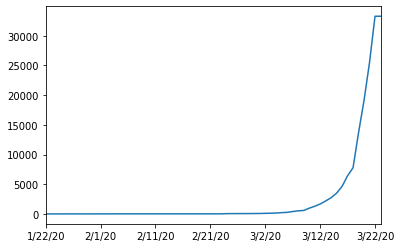

In [204]:
df_world['US'].sum(axis=1).plot()
print(str(max(df_world['US'].sum(axis=1))))

In [221]:
df_world = df_world.groupby(df_world.columns, axis=1).sum()

In [262]:
df_world.max().idxmax()

'China'

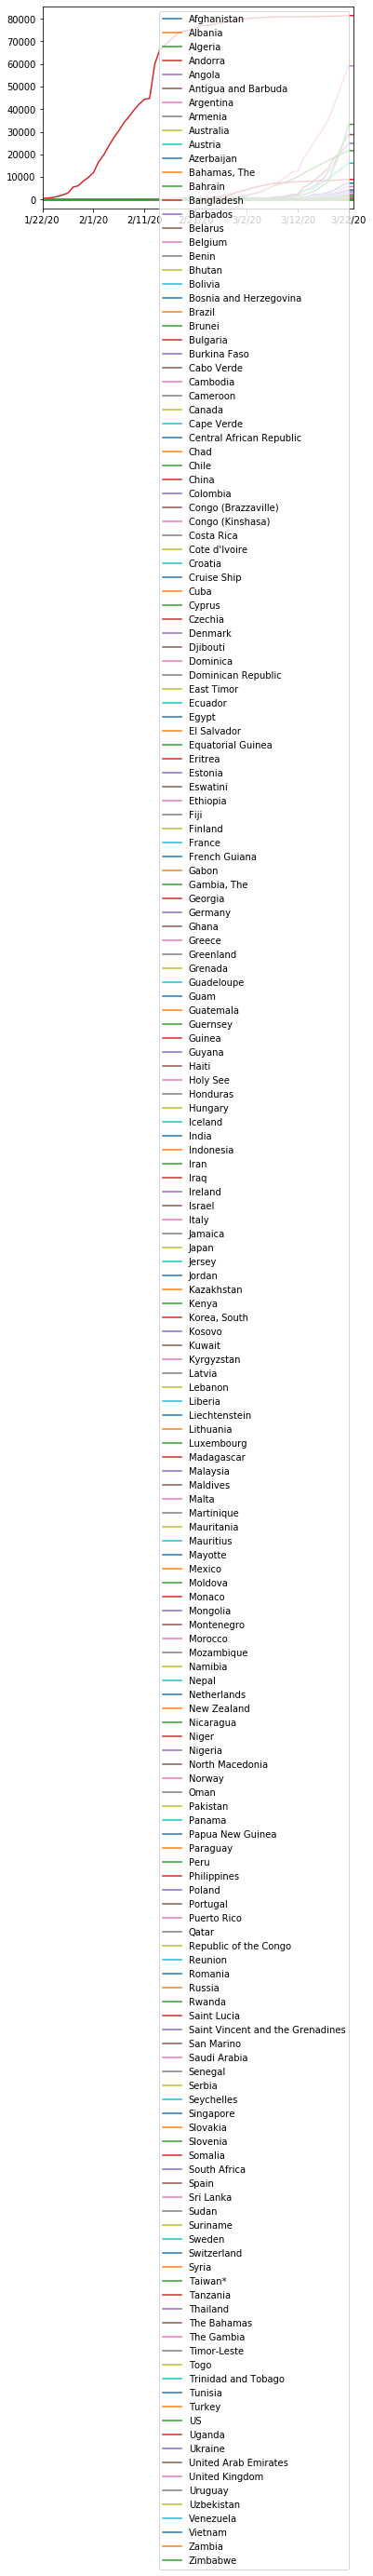

In [222]:
df_world.plot()

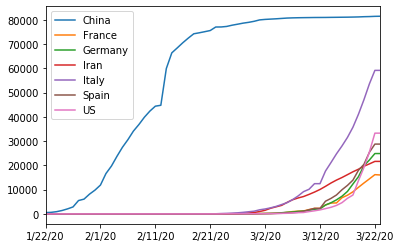

In [271]:
df_world[df_world.columns[df_world.max()>10000]].plot()

In [272]:
df_world.groupby(df_world.columns, axis=1).max()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/19/20,22.0,64.0,87.0,53.0,0.0,1.0,97.0,115.0,681.0,2013.0,...,0.0,16.0,140.0,2716.0,79.0,23.0,42.0,85.0,2.0,0.0
3/20/20,24.0,70.0,90.0,75.0,1.0,1.0,128.0,136.0,791.0,2388.0,...,0.0,29.0,140.0,4014.0,94.0,33.0,42.0,91.0,2.0,1.0
3/21/20,24.0,76.0,139.0,88.0,2.0,1.0,158.0,160.0,1071.0,2814.0,...,1.0,47.0,153.0,5067.0,110.0,43.0,70.0,94.0,2.0,3.0
3/22/20,40.0,89.0,201.0,113.0,2.0,1.0,225.0,194.0,1314.0,3244.0,...,1.0,73.0,153.0,5741.0,135.0,43.0,70.0,113.0,3.0,3.0


# Playground

In [8]:
def SIRmodel_logbeta(tijdstappen, S_0, I_0, R_0, log10_beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(10**(log10_beta), gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        fig, axes = plt.subplots(1,1, figsize=(10,10))
        axes.set_xlabel('time')
        axes.set_ylabel('Population')

        axes.plot(COVID19_totalConf, 'rx')
        axes.plot(modeloutput);
#         modeloutput.plot()
        
    if returnDataFrame:
        return modeloutput 

In [9]:
# fig, axes = plt.subplots(1,1)
# axes.set_xlabel('time')
# axes.set_ylabel('Population')

interact(SIRmodel_logbeta, 
         tijdstappen=fixed(np.arange(0., 1000, 1)), 
         COVID19_totalConf=COVID19_totalConf,
                   S_0=FloatSlider(value=2*COVID19_totalConf.max()[0], 
                                   min=1.5*COVID19_totalConf.max()[0], 
                                   max=5000000, 
                                   step=100000,
                                   continuous_update=False, readout_format='.2e'), 
                   I_0=fixed(1), R_0=fixed(0),
                   log10_beta=FloatSlider(value=-7, min=-8, max=-6, step=0.001,
                                    continuous_update=True, readout_format='.2e'),
                   gamma=FloatSlider(value=0.01, min=0, max=0.05, step=0.001,
                                     continuous_update=False, readout_format='.2e'),
                   returnDataFrame=fixed(False));
# axes.plot(COVID19_totalConf, 'rx')

interactive(children=(FloatSlider(value=672008.0, continuous_update=False, description='S_0', max=5000000.0, m…

# Cases in Italy (source https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

In [10]:
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [11]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

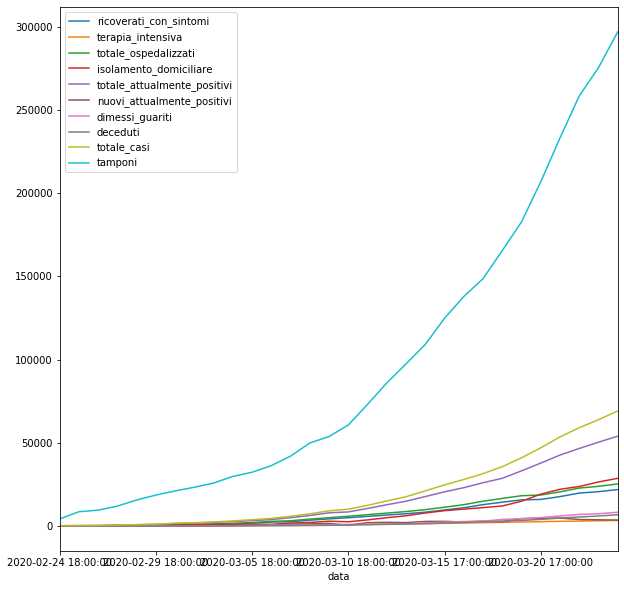

In [12]:
df.set_index('data').plot(figsize=(10,10));

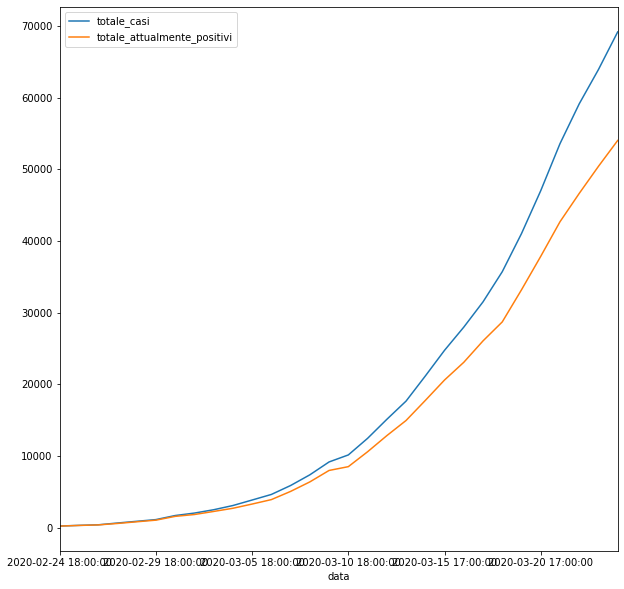

In [13]:
df.set_index('data')[['totale_casi', 'totale_attualmente_positivi']].plot(figsize=(10,10));

In [14]:
dfn = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = dfn['data']
dfn['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

In [15]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [16]:
x = list(dfn.iloc[:,0])
y = list(dfn.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[5,100,2000])

In [17]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [18]:
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
print('Coeff is '+str(round(a)))
print('Coeff is '+str(round(b)))
print('Total predicted infected '+str(round(c))+ ' +-'+str(round(errors[2])))

Coeff is 5.0
Coeff is 81.0
Total predicted infected 114858.0 +-3915.0


In [19]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

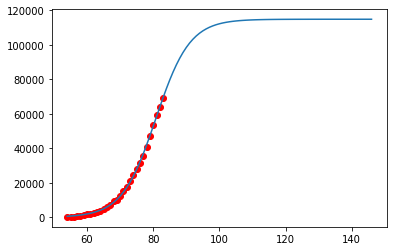

In [20]:
pred_x = list(range(max(x),sol))
# plt.rcParams['figure.figsize'] = [7, 7]
# plt.rc('font', size=14)
# Real data
plt.scatter(x,y, label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" );

In [21]:
preddf = pd.DataFrame([pd.to_datetime('2020-01-01 18:00:00') + pd.to_timedelta(x+pred_x, unit='D'), 
                       [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x]]).T
preddf.columns = ['data', 'totale_casi']
preddf = preddf.set_index('data')

In [22]:
dftotale = pd.DataFrame(df.set_index('data')['totale_casi'])
dftotale.index = pd.to_datetime(dftotale.index)

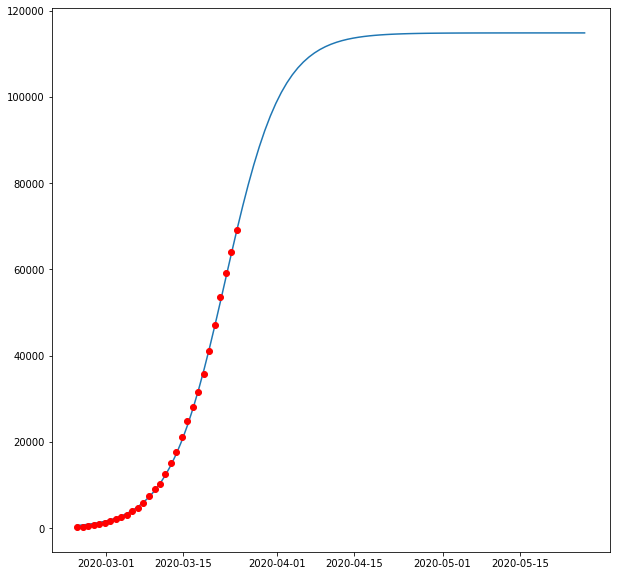

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(preddf)
ax.plot(dftotale, 'or');

In [24]:
def SIRmodel_logbeta(tijdstappen, S_0, I_0, R_0, log10_beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(10**(log10_beta), gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        fig, axes = plt.subplots(1,1, figsize=(10,10))
        axes.set_xlabel('time')
        axes.set_ylabel('Population')

        axes.plot(dftotale, 'rx')
        axes.plot(modeloutput);
#         modeloutput.plot()
        
    if returnDataFrame:
        return modeloutput 

In [27]:

interact(SIRmodel_logbeta, 
         tijdstappen=fixed(np.arange(0., 1000, 1)), 
         COVID19_totalConf=COVID19_totalConf,
                   S_0=FloatSlider(value=c, 
                                   min=0.5*c, 
                                   max=10*c, 
                                   step=c/1000,
                                   continuous_update=False, readout_format='.2e'), 
                   I_0=fixed(1), R_0=fixed(0),
                   log10_beta=FloatSlider(value=-6.5, min=-8, max=-5, step=0.0001,
                                    continuous_update=True, readout_format='.2e'),
                   gamma=FloatSlider(value=0.03, min=0, max=0.05, step=0.001,
                                     continuous_update=False, readout_format='.2e'),
                   returnDataFrame=fixed(False));

interactive(children=(FloatSlider(value=114858.24742238276, continuous_update=False, description='S_0', max=11…